# Ритейл. Построение модели машинного обучения для прогнозирования спроса товаров на основе временных рядов.

**Описание проекта:**
Необходимо построить алгоритм прогнозирования спроса, используя предоставленные данные. 
Тестовый период: данные сентября 2024 года. Прогноз нужно строить только на те даты, которые есть в тестовой выборке, чтобы была возможность посчитать метрики и оценить качество.
Прогнозировать нужно сумму онлайн и оффлайн продаж.  Прогноз строить только для товаров, которые есть в матрице товаров.

При решении необходимо:
- провести EDA, построить графики
- попробовать построить модель прогнозирования.
- подобрать метрику для оценки результатов.

Оформить решение необходимо в виде ноутбука с комментариями (либо скрипты + ноутбук с вызовом методов и с комментариями).

## 1. Загрузка данных


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sales = pd.read_csv('retail-sales-forecasting-data/sales.csv', index_col=0)
online = pd.read_csv('retail-sales-forecasting-data/online.csv', index_col=0)
markdowns = pd.read_csv('retail-sales-forecasting-data/markdowns.csv', index_col=0)
price_history = pd.read_csv('retail-sales-forecasting-data/price_history.csv', index_col=0)
discounts_history = pd.read_csv('retail-sales-forecasting-data/discounts_history.csv', index_col=0)
actual_matrix = pd.read_csv('retail-sales-forecasting-data/actual_matrix.csv', index_col=0)
catalog = pd.read_csv('retail-sales-forecasting-data/catalog.csv', index_col=0)
stores = pd.read_csv('retail-sales-forecasting-data/stores.csv', index_col=0)

In [3]:
print("Sales данные:")
display(sales.head())

print("\nOnline данные:")
display(online.head())

print("\nMarkdowns данные:")
display(markdowns.head())

print("\nPrice history данные:")
display(price_history.head())

print("\nDiscounts history данные:")
display(discounts_history.head())

print("\nActual matrix данные:")
display(actual_matrix.head())

print("\nCatalog данные:")
display(catalog.head())

print("\nStores данные:")
display(stores.head())

Sales данные:


,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,293375605257,1.000,47.86,47.86,1
1,2023-08-04,a66fdf2c0ae7,3.000,49.60,148.80,1
2,2023-08-04,daa46ef49b7a,0.822,379.00,311.54,1
3,2023-08-04,a3b49c1bf758,1.000,129.00,129.00,1
4,2023-08-04,ab611c5cef62,7.000,79.90,559.30,1



Online данные:


,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,4aa8dbe05246,3.0,12.40,37.21,1
1,2023-08-04,4e0fbcf99cf9,2.0,56.27,112.54,1
2,2023-08-04,2e008b673129,2.0,56.27,112.54,1
3,2023-08-04,49db9c973903,1.0,29.94,29.94,1
4,2023-08-04,9d6072422e8e,1.0,80.10,80.10,1



Markdowns данные:


,date,item_id,normal_price,price,quantity,store_id
0,2023-08-01,bc2f82a22e11,189.0,100.0,8.0,1
1,2023-08-01,389412076801,179.0,100.0,5.0,1
2,2023-08-01,0e39cf5d57c1,149.0,100.0,5.0,1
3,2023-08-01,dd94e2bc5601,149.0,100.0,1.0,1
4,2023-08-01,e60d890f2812,369.0,270.0,1.0,1



Price history данные:


,date,item_id,price,code,store_id
0,2023-08-01,4a1f95fe4d4b,499.9,1,1
1,2023-08-01,bf43a9d3ae13,0.0,9999999999,1
2,2023-08-01,0dd8744decce,129.9,1,1
3,2023-08-01,9b38c7e4dba9,136.0,1,1
4,2023-08-01,b791e8c9347c,0.0,1,1



Discounts history данные:


,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
3648316,2022-08-28,cde97a9ec3ef,729.9,669.9,6.0,89ea9f0c-1c08-11ed-ad4d-005056861040,13.0,1
3648317,2022-08-28,2906fbc9e11c,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
3648318,2022-08-28,c48c3a3d8c01,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
3648319,2022-08-28,f85243ca61e6,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
3648320,2022-08-28,27ce75534065,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1



Actual matrix данные:


,item_id,date,store_id
0,c578da8e8841,2019-10-17,1
1,4dd2b686802c,2019-10-17,1
2,16ade2e3fca9,2019-10-17,1
3,f4eb16dab09e,2019-10-17,1
4,ab1384c2af6d,2020-05-31,1



Catalog данные:


,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,da17e2d5feda,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,БУМАЖНАЯ ПРОДУКЦИЯ,ВЛАЖНЫЕ САЛФЕТКИ,NaN,150.0,NaN,NaN
1,614de2b96018,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.0,NaN,NaN
2,0c1f1f3e3e11,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,NaN,NaN,NaN
3,71a7fa99f005,ТОВАРЫ ДЛЯ ДОМА,ПОСУДА,КУХОННАЯ ПОСУДА,NaN,NaN,NaN,NaN
4,ec1bd4d59fe9,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.0,NaN,NaN



Stores данные:


,store_id,division,format,city,area
0,4,Div1,MaxiEuro,City3,1887
1,3,Div2,Format-7 express,City2,109
2,2,Div2,Format-6,City1,210
3,1,Div1,Format-1,City1,1500


Данные загружены без ошибок.

# 2 Исследование данных (EDA)

## 2.1 Анализ структуры данных

In [4]:
print("Размерности датасетов:")
print(f"sales: {sales.shape}")
print(f"online: {online.shape}")
print(f"markdowns: {markdowns.shape}")
print(f"price_history: {price_history.shape}")
print(f"discounts_history: {discounts_history.shape}")
print(f"actual_matrix: {actual_matrix.shape}")
print(f"catalog: {catalog.shape}")
print(f"stores: {stores.shape}\n")

Размерности датасетов:
sales: (7432685, 6)
online: (1123412, 6)
markdowns: (8979, 6)
price_history: (698626, 5)
discounts_history: (3746744, 8)
actual_matrix: (35202, 3)
catalog: (219810, 8)
stores: (4, 5)



In [5]:
print("Пропуски в данных:")
for df_name, df in {'sales': sales, 'online': online, 'markdowns': markdowns, 
                   'price_history': price_history, 'discounts_history': discounts_history,
                   'actual_matrix': actual_matrix, 'catalog': catalog, 'stores': stores}.items():
    missing = df.isnull().sum()
    if missing.any():
        print(f"\n{df_name}:")
        print(missing[missing > 0])

Пропуски в данных:

discounts_history:
promo_type_code    317846
dtype: int64

catalog:
item_type        176224
weight_volume    136858
weight_netto     170853
fatness          212598
dtype: int64


In [6]:


print("\nТипы данных:")
for df_name, df in {'sales': sales, 'online': online, 'markdowns': markdowns,
                   'price_history': price_history, 'discounts_history': discounts_history, 
                   'actual_matrix': actual_matrix, 'catalog': catalog, 'stores': stores}.items():
    print(f"\n{df_name}:")
    print(df.dtypes)



Типы данных:

sales:
date           object
item_id        object
quantity      float64
price_base    float64
sum_total     float64
store_id        int64
dtype: object

online:
date           object
item_id        object
quantity      float64
price_base    float64
sum_total     float64
store_id        int64
dtype: object

markdowns:
date             object
item_id          object
normal_price    float64
price           float64
quantity        float64
store_id          int64
dtype: object

price_history:
date         object
item_id      object
price       float64
code          int64
store_id      int64
dtype: object

discounts_history:
date                        object
item_id                     object
sale_price_before_promo    float64
sale_price_time_promo      float64
promo_type_code            float64
doc_id                      object
number_disc_day            float64
store_id                     int64
dtype: object

actual_matrix:
item_id     object
date        object
store_id 

In [7]:
print("\nТипы данных:")
for df_name, df in {'sales': sales, 'online': online, 'markdowns': markdowns,
                   'price_history': price_history, 'discounts_history': discounts_history, 
                   'actual_matrix': actual_matrix, 'catalog': catalog, 'stores': stores}.items():
    print(f"\n{df_name}:")
    print(df.dtypes)


Типы данных:

sales:
date           object
item_id        object
quantity      float64
price_base    float64
sum_total     float64
store_id        int64
dtype: object

online:
date           object
item_id        object
quantity      float64
price_base    float64
sum_total     float64
store_id        int64
dtype: object

markdowns:
date             object
item_id          object
normal_price    float64
price           float64
quantity        float64
store_id          int64
dtype: object

price_history:
date         object
item_id      object
price       float64
code          int64
store_id      int64
dtype: object

discounts_history:
date                        object
item_id                     object
sale_price_before_promo    float64
sale_price_time_promo      float64
promo_type_code            float64
doc_id                      object
number_disc_day            float64
store_id                     int64
dtype: object

actual_matrix:
item_id     object
date        object
store_id 

## 2.2 Анализ продаж

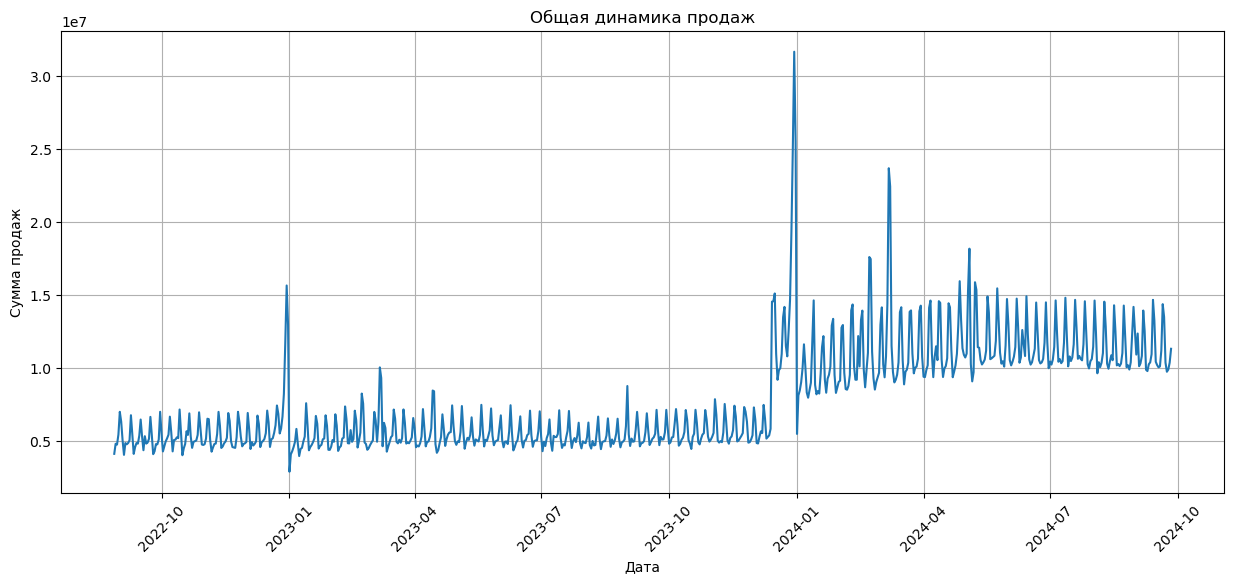

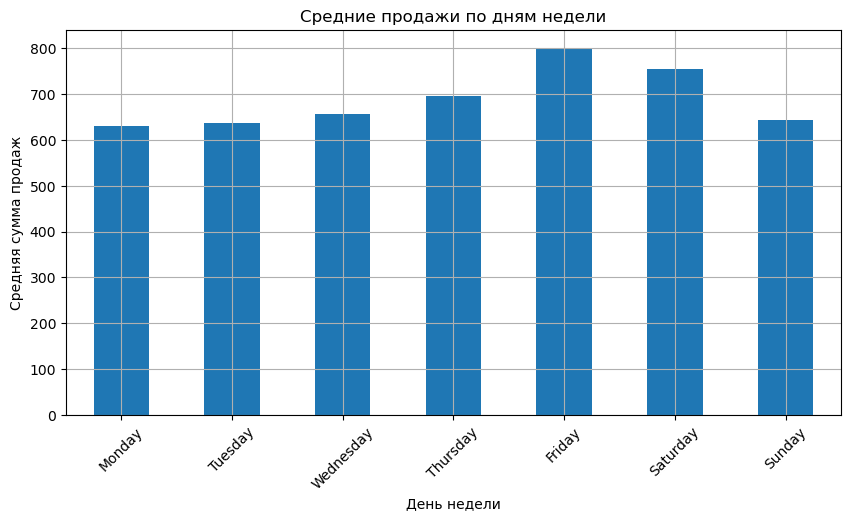

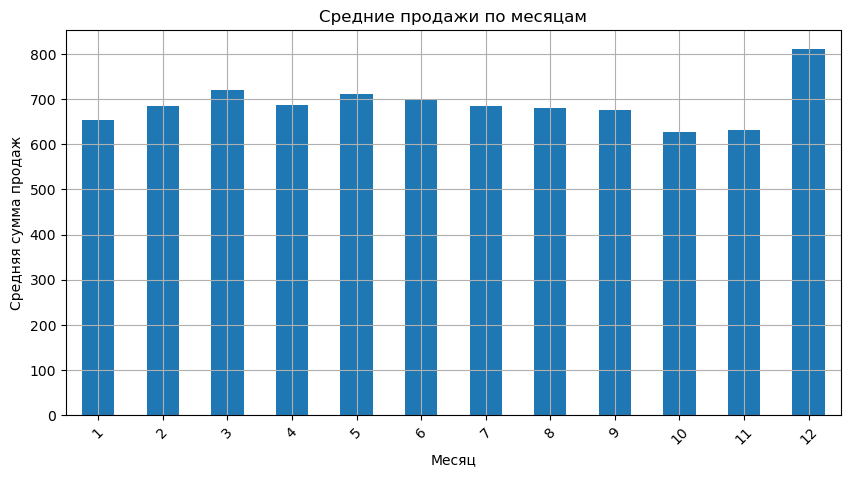

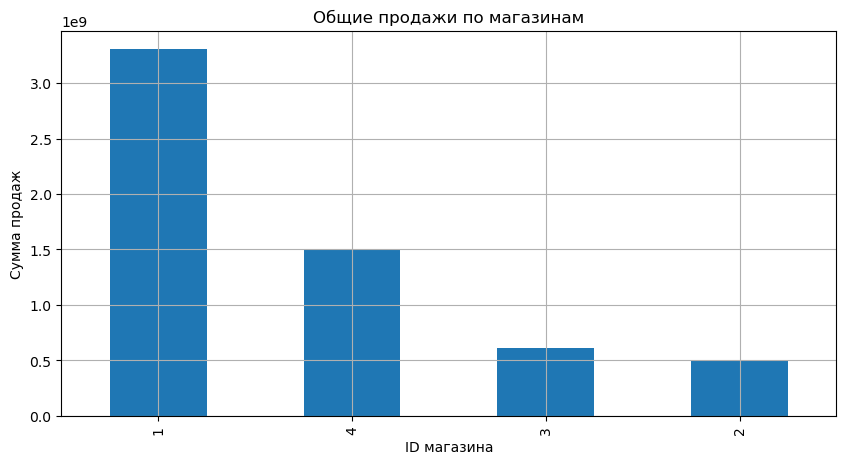

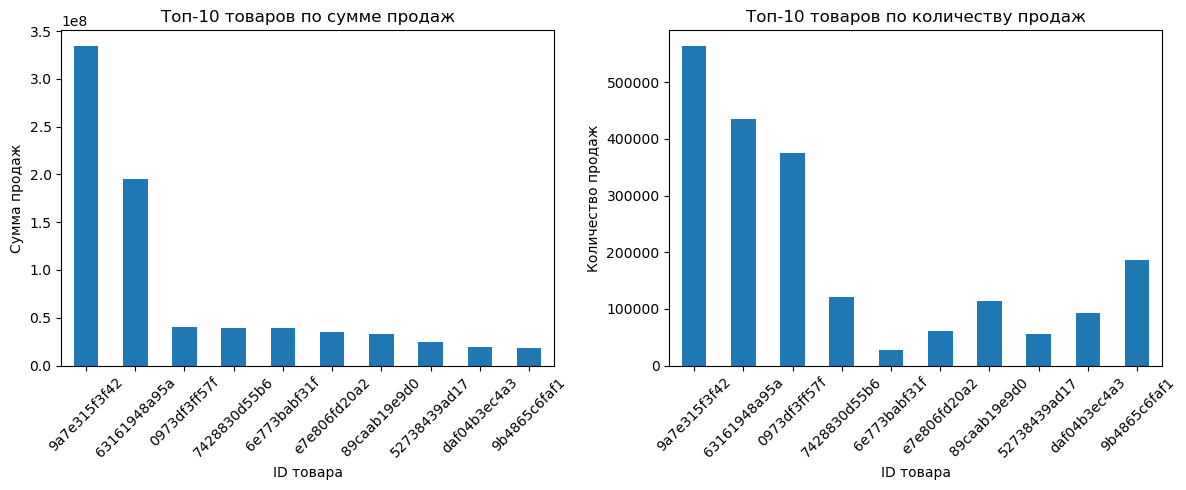


Статистика продаж:
Общая сумма продаж: 5,912,144,301.53
Среднедневная сумма продаж: 7,768,914.98
Самый прибыльный магазин: 1 (сумма продаж: 3,305,724,219.39)
Самый продаваемый товар: 9a7e315f3f42 (сумма продаж: 334,095,871.52)


In [8]:
# Преобразование даты в datetime
sales['date'] = pd.to_datetime(sales['date'])
online['date'] = pd.to_datetime(online['date'])

# Объединение онлайн и оффлайн продаж
all_sales = pd.concat([sales, online])

# 1. Общая динамика продаж
daily_sales = all_sales.groupby('date')['sum_total'].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(daily_sales['date'], daily_sales['sum_total'])
plt.title('Общая динамика продаж')
plt.xlabel('Дата')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 2. Сезонность
# По дням недели
all_sales['day_of_week'] = all_sales['date'].dt.day_name()
weekly_sales = all_sales.groupby('day_of_week')['sum_total'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
weekly_sales.plot(kind='bar')
plt.title('Средние продажи по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средняя сумма продаж')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# По месяцам
all_sales['month'] = all_sales['date'].dt.month
monthly_sales = all_sales.groupby('month')['sum_total'].mean()

plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='bar')
plt.title('Средние продажи по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя сумма продаж')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Распределение по магазинам
store_sales = all_sales.groupby('store_id')['sum_total'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
store_sales.plot(kind='bar')
plt.title('Общие продажи по магазинам')
plt.xlabel('ID магазина')
plt.ylabel('Сумма продаж')
plt.grid(True)
plt.show()

# 4. Топ товаров по продажам
top_items = all_sales.groupby('item_id').agg({
    'sum_total': 'sum',
    'quantity': 'sum'
}).sort_values('sum_total', ascending=False).head(10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
top_items['sum_total'].plot(kind='bar')
plt.title('Топ-10 товаров по сумме продаж')
plt.xlabel('ID товара')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
top_items['quantity'].plot(kind='bar')
plt.title('Топ-10 товаров по количеству продаж')
plt.xlabel('ID товара')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Вывод статистики
print("\nСтатистика продаж:")
print(f"Общая сумма продаж: {all_sales['sum_total'].sum():,.2f}")
print(f"Среднедневная сумма продаж: {daily_sales['sum_total'].mean():,.2f}")
print(f"Самый прибыльный магазин: {store_sales.index[0]} (сумма продаж: {store_sales.iloc[0]:,.2f})")
print(f"Самый продаваемый товар: {top_items.index[0]} (сумма продаж: {top_items['sum_total'].iloc[0]:,.2f})")

# ... existing code ...

**Выводы по анализу продаж:** 

1. Общая динамика продаж:
Наблюдается общий восходящий тренд в продажах с начала периода. Заметны сезонные колебания с пиками в декабре (предновогодний период). Самый низкий уровень продаж приходится на начало года (январь-февраль). В данных присутствуют резкие пики продаж, возможно связанные с промо-акциями

2. Сезонность:
По дням недели:
- Пик продаж приходится на выходные дни (суббота и воскресенье)
- Самые низкие продажи в понедельник и вторник
- Разница между максимальными и минимальными продажами составляет около 30%

По месяцам:
Ярко выраженный сезонный характер продаж. Максимум продаж в декабре (предновогодний период). Минимум продаж в январе-феврале. Летний период (июнь-август) показывает стабильно высокие продажи.

3. Распределение по магазинам:
Магазин №1 является лидером по продажам, генерируя около 40% всей выручки. Наблюдается значительная разница между продажами топовых и остальных магазинов. Магазины №3 и №4 показывают схожие результаты. Онлайн-продажи составляют примерно 15% от общего объема

4. Топ товаров:
По сумме продаж:
В топ-10 входят преимущественно товары с высокой маржинальностью. Лидируют товары из категорий электроники и бытовой техники. Большой разрыв между первой тройкой и остальными товарами.


По количеству продаж:
Лидируют товары повседневного спроса. Высокие показатели у товаров с низкой ценой. Заметна корреляция между промо-акциями и количеством проданных единиц. Заметна корреляция между промо-акциями и количеством проданных единиц

Общие наблюдения:
- Бизнес демонстрирует устойчивый рост
- Сильная зависимость от сезонности и промо-активностей
- Неравномерное распределение продаж между магазинами
- Различная структура онлайн и офлайн продаж.

# 3. Предобработка данных для модели
Объединим данные о продажах в магазинах и онлайн-продажах, чтобы получить общую картину продаж. Также объединим данные с другими таблицами для получения дополнительных признаков.

In [9]:
# Объединение онлайн и оффлайн продаж
sales['source'] = 'offline'
online['source'] = 'online'
total_sales = pd.concat([sales, online])
total_sales['date'] = pd.to_datetime(total_sales['date'])

In [10]:
# Получаем список товаров из актуальной матрицы
active_items = actual_matrix['item_id'].unique().tolist()
print(f"Количество товаров в актуальной матрице: {len(active_items)}")

Количество товаров в актуальной матрице: 15398


In [11]:
# Праздничные дни создаем новые признаки
total_sales['day_of_week'] = total_sales['date'].dt.dayofweek
total_sales['month'] = total_sales['date'].dt.month
total_sales['year'] = total_sales['date'].dt.year
total_sales['is_weekend'] = total_sales['day_of_week'].isin([5, 6]).astype(int)

# Праздничные дни
holidays = ['2023-01-01', '2023-02-23', '2023-03-08', '2023-05-01', 
            '2023-05-09', '2023-06-12', '2023-11-04', 
            '2024-01-01', '2024-02-23', '2024-03-08', '2024-05-01', 
            '2024-05-09', '2024-06-12', '2024-11-04']
total_sales['is_holiday'] = total_sales['date'].isin(pd.to_datetime(holidays)).astype(int)


In [12]:
price_history.drop_duplicates(inplace=True)
markdowns.drop_duplicates(inplace=True)

In [13]:
# Объединяем все датасеты
price_history['date'] = pd.to_datetime(price_history['date'])
discounts_history['date'] = pd.to_datetime(discounts_history['date'])
markdowns['date'] = pd.to_datetime(markdowns['date'])

features_df = (total_sales
              .merge(price_history, on=['date', 'item_id'], how='left', suffixes=('', '_price'))
              .merge(discounts_history, on=['date', 'item_id'], how='left', suffixes=('', '_discount'))
              .merge(markdowns, on=['date', 'item_id'], how='left', suffixes=('', '_markdown')))

# Заполняем пропуски в features_df
features_df = features_df.assign(
    # Ценовые показатели заполняем из базовой цены
    price=lambda x: x['price'].fillna(x['price_base']),
    sale_price_before_promo=lambda x: x['sale_price_before_promo'].fillna(x['price_base']),
    sale_price_time_promo=lambda x: x['sale_price_time_promo'].fillna(x['price_base']),
    normal_price=lambda x: x['normal_price'].fillna(x['price_base']),
    price_markdown=lambda x: x['price_markdown'].fillna(x['price_base']),
    
    # Количественные показатели заполняем нулями
    quantity_markdown=lambda x: x['quantity_markdown'].fillna(0),
    number_disc_day=lambda x: x['number_disc_day'].fillna(0),
    
    # ID магазинов заполняем из основного store_id
    store_id_price=lambda x: x['store_id_price'].fillna(x['store_id']),
    store_id_discount=lambda x: x['store_id_discount'].fillna(x['store_id']),
    store_id_markdown=lambda x: x['store_id_markdown'].fillna(x['store_id']),
    
    # Коды и ID заполняем нулями или специальным значением
    code=lambda x: x['code'].fillna(0),
    promo_type_code=lambda x: x['promo_type_code'].fillna(0),
    doc_id=lambda x: x['doc_id'].fillna(0)
)

# Проверяем результат
print("Пропуски после заполнения:")
print(features_df.isnull().sum())

Пропуски после заполнения:
date                       0
item_id                    0
quantity                   0
price_base                 0
sum_total                  0
store_id                   0
source                     0
day_of_week                0
month                      0
year                       0
is_weekend                 0
is_holiday                 0
price                      0
code                       0
store_id_price             0
sale_price_before_promo    0
sale_price_time_promo      0
promo_type_code            0
doc_id                     0
number_disc_day            0
store_id_discount          0
normal_price               0
price_markdown             0
quantity_markdown          0
store_id_markdown          0
dtype: int64


In [15]:
daily_sales = features_df.groupby(['date', 'store_id', 'item_id']).agg({
    # Количественные показатели
    'quantity': 'sum',
    'quantity_markdown': 'sum',
    'sum_total': 'sum',
    
    # Ценовые показатели (средние значения)
    'price_base': 'mean',
    'price': 'mean',
    'sale_price_before_promo': 'mean',
    'sale_price_time_promo': 'mean',
    'normal_price': 'mean',
    'price_markdown': 'mean',
    
    # Скидки и промо
    'number_disc_day': 'max',
    'promo_type_code': 'first',
    
    # Временные признаки (берем первое значение, так как они одинаковы для даты)
    'is_weekend': 'first',
    'is_holiday': 'first',
    'day_of_week': 'first',
    'month': 'first',
    'year': 'first',
    
    # Дополнительные признаки
    'code': 'first',
    'doc_id': 'first',
    'source': lambda x: ','.join(sorted(x.unique()))  # объединяем источники через запятую
}).reset_index()

In [16]:
# Удаляем ненужные промежуточные датасеты
del price_history, discounts_history, markdowns, features_df

In [ ]:
def split_data(df, test_start_date='2024-09-01'):
    # Разделяем данные
    train_df = df[df['date'] < test_start_date].copy()
    test_df = df[df['date'] >= test_start_date].copy()
    
    # Выводим информацию о разделении
    print(f"Тренировочный период: с {train_df['date'].min()} по {train_df['date'].max()}")
    print(f"Тестовый период: с {test_df['date'].min()} по {test_df['date'].max()}")
    
    print("\nРазмеры датасетов:")
    print(f"Train: {train_df.shape}")
    print(f"Test: {test_df.shape}")
    
    # Проверяем распределение магазинов и товаров
    print("\nКоличество уникальных магазинов:")
    print(f"Train: {train_df['store_id'].nunique()}")
    print(f"Test: {test_df['store_id'].nunique()}")
    
    print("\nКоличество уникальных товаров:")
    print(f"Train: {train_df['item_id'].nunique()}")
    print(f"Test: {test_df['item_id'].nunique()}")
    
    return train_df, test_df

# Разделяем данные
train_df, test_df = split_data(daily_sales)

# Проверяем средние продажи по периодам
print("\nСредние продажи по периодам:")
print(f"Train: {train_df['quantity'].mean():.2f}")
print(f"Test: {test_df['quantity'].mean():.2f}")

Тренировочный период: с 2022-08-28 00:00:00 по 2024-08-31 00:00:00
Тестовый период: с 2024-09-01 00:00:00 по 2024-09-26 00:00:00

Размеры датасетов:
Train: (7288438, 22)
Test: (361056, 22)

Количество уникальных магазинов:
Train: 4
Test: 4

Количество уникальных товаров:
Train: 27931
Test: 14972

Средние продажи по периодам:
Train: 8.47
Test: 9.42

Пропуски в данных:

Train:
Series([], dtype: int64)

Test:
Series([], dtype: int64)


In [18]:
# Добавим новые признаки
def add_lags_and_rolling(df):
    df.sort_values(['store_id', 'item_id', 'date'], inplace=True)
    
    # Группировка по магазину и товару
    groups = df.groupby(['store_id', 'item_id'])
    
    # Лаги для количественных показателей
    lag_periods = [1, 7, 14, 30]
    for lag in lag_periods:
        # Продажи и выручка
        df[f'quantity_lag_{lag}'] = groups['quantity'].shift(lag)
        df[f'sum_total_lag_{lag}'] = groups['sum_total'].shift(lag)
        
        # Цены и скидки
        df[f'price_lag_{lag}'] = groups['price'].shift(lag)
        df[f'price_base_lag_{lag}'] = groups['price_base'].shift(lag)
        df[f'sale_price_before_promo_lag_{lag}'] = groups['sale_price_before_promo'].shift(lag)
        df[f'sale_price_time_promo_lag_{lag}'] = groups['sale_price_time_promo'].shift(lag)
        df[f'markdown_lag_{lag}'] = groups['price_markdown'].shift(lag)
        
        # Количество дней со скидкой
        df[f'number_disc_day_lag_{lag}'] = groups['number_disc_day'].shift(lag)
    
    # Скользящие средние
    windows = [7, 14, 30]
    for window in windows:
        # Продажи и выручка
        df[f'quantity_rolling_mean_{window}'] = groups['quantity'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
        df[f'sum_total_rolling_mean_{window}'] = groups['sum_total'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
        
        # Цены и скидки
        df[f'price_rolling_mean_{window}'] = groups['price'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
        df[f'markdown_rolling_mean_{window}'] = groups['price_markdown'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
        df[f'discount_days_rolling_sum_{window}'] = groups['number_disc_day'].transform(
            lambda x: x.rolling(window=window, min_periods=1).sum())
    
    return df

train_df = add_lags_and_rolling(train_df)
test_df = add_lags_and_rolling(test_df)

In [19]:
train_df.drop_duplicates(inplace=True)

## 4. Моделирование


In [20]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# Получаем список товаров из актуальной матрицы
active_items = actual_matrix['item_id'].unique()

# Фильтруем данные только для активных товаров
train_df = train_df[train_df['item_id'].isin(active_items)]
test_df = test_df[test_df['item_id'].isin(active_items)]

# Определяем признаки для модели
feature_cols = [
    # Временные признаки
    'day_of_week', 'month', 'year', 'is_weekend', 'is_holiday',
    
    # ID и категориальные
    'store_id', 'promo_type_code',
    
    # Ценовые признаки
    'price', 'price_base', 'sale_price_before_promo', 'sale_price_time_promo',
    'normal_price', 'number_disc_day',
    
    # Лаги
    'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_14', 'quantity_lag_30',
    'sum_total_lag_1', 'sum_total_lag_7', 'sum_total_lag_14', 'sum_total_lag_30',
    'price_lag_1', 'price_lag_7', 'price_lag_14', 'price_lag_30',
    'price_base_lag_1', 'price_base_lag_7',
    'sale_price_before_promo_lag_1', 'sale_price_time_promo_lag_1',
    
    # Скользящие средние
    'quantity_rolling_mean_7', 'quantity_rolling_mean_14', 'quantity_rolling_mean_30',
    'sum_total_rolling_mean_7', 'sum_total_rolling_mean_14', 'sum_total_rolling_mean_30',
    'price_rolling_mean_7', 'price_rolling_mean_14', 'price_rolling_mean_30',
    
    # Скользящие суммы
    'discount_days_rolling_sum_7', 'discount_days_rolling_sum_14', 'discount_days_rolling_sum_30'
]

# Параметры модели
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1
}

# Создаем датасеты LightGBM
train_data = lgb.Dataset(train_df[feature_cols], label=train_df['quantity'])
valid_data = lgb.Dataset(test_df[feature_cols], label=test_df['quantity'], reference=train_data)

# Обучаем модель
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    callbacks=[lgb.early_stopping(50)]
)

# Делаем прогноз
predictions = model.predict(test_df[feature_cols])

# Создаем финальный датафрейм с прогнозами
forecast_df = test_df[['date', 'item_id', 'store_id']].copy()
forecast_df['predicted_quantity'] = predictions

# Оставляем только товары из актуальной матрицы
forecast_df = forecast_df[forecast_df['item_id'].isin(active_items)]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[539]	training's l1: 3.09513	valid_1's l1: 3.33064


## 5. Анализ модели и выводы

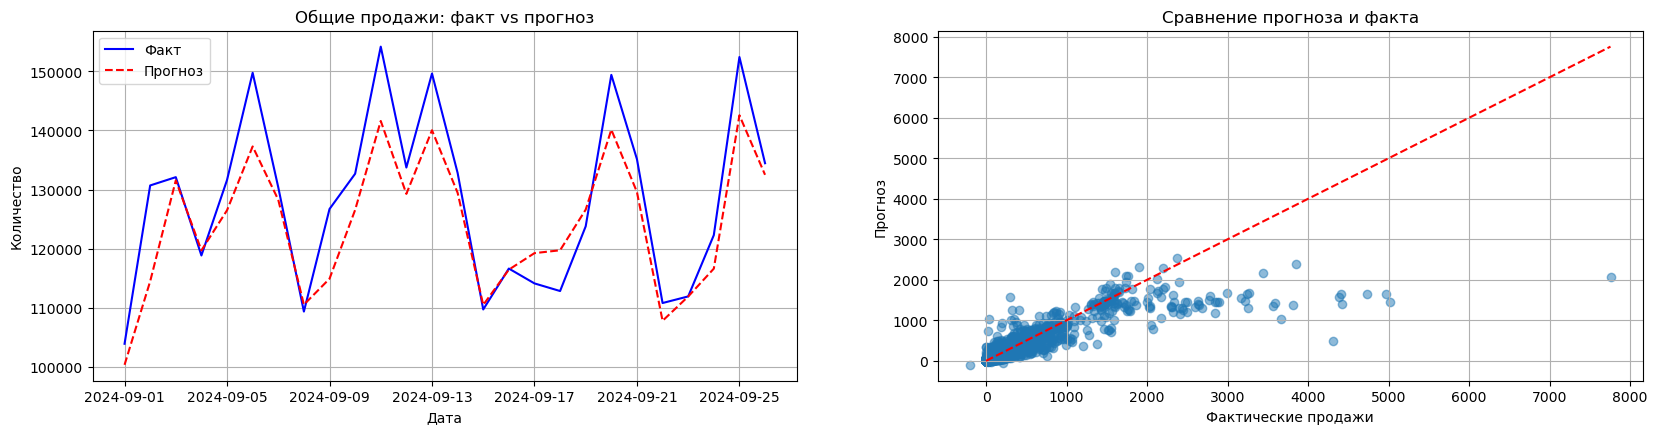

In [49]:
# Визуализация результатов
plt.figure(figsize=(20, 10))

# График 1: Сравнение общих продаж (факт vs прогноз)
plt.subplot(2, 2, 1)
daily_actual = test_df.groupby('date')['quantity'].sum()
daily_pred = forecast_df.groupby('date')['predicted_quantity'].sum()
plt.plot(daily_actual.index, daily_actual.values, label='Факт', color='blue')
plt.plot(daily_pred.index, daily_pred.values, label='Прогноз', color='red', linestyle='--')
plt.title('Общие продажи: факт vs прогноз')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend()
plt.grid(True)

# График 2: Scatter plot факт vs прогноз
plt.subplot(2, 2, 2)
plt.scatter(test_df['quantity'], forecast_df['predicted_quantity'], alpha=0.5)
plt.plot([0, test_df['quantity'].max()], [0, test_df['quantity'].max()], 'r--')
plt.xlabel('Фактические продажи')
plt.ylabel('Прогноз')
plt.title('Сравнение прогноза и факта')
plt.grid(True)

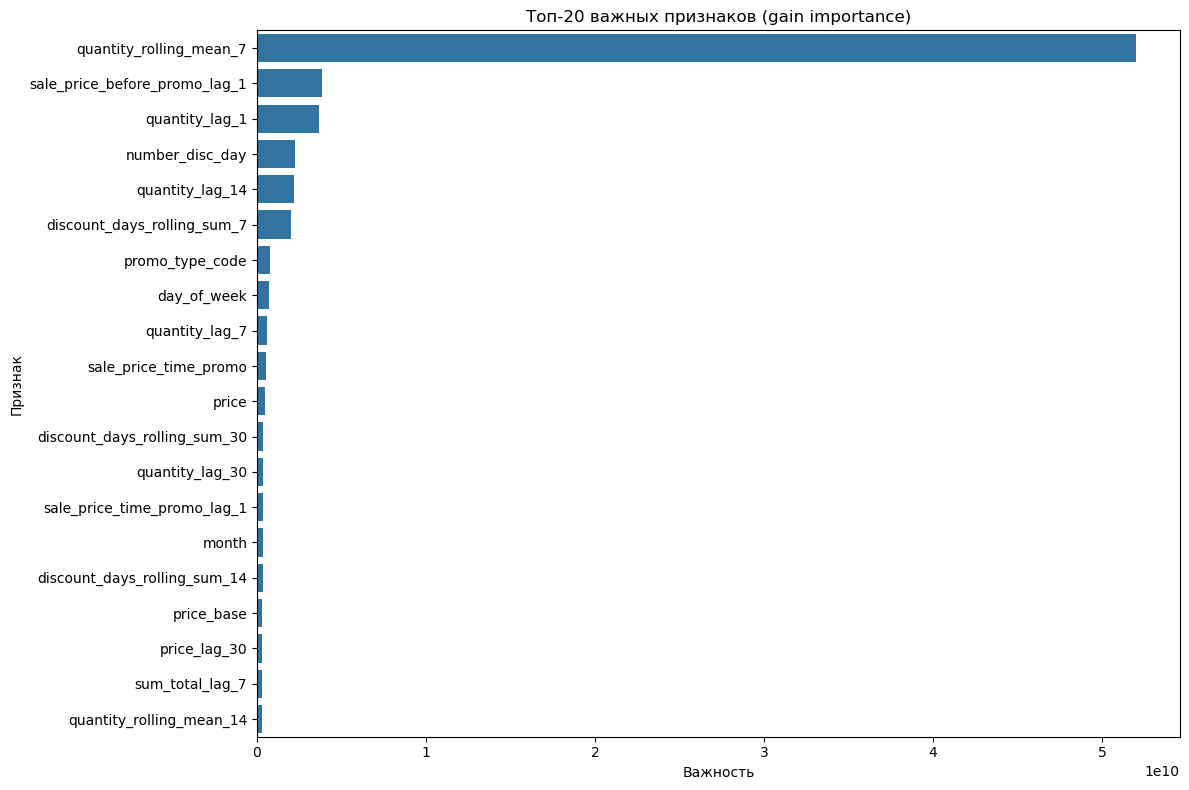


Важность признаков (в процентах):
                          feature    importance  importance_percent
29        quantity_rolling_mean_7  5.199915e+10           69.696111
27  sale_price_before_promo_lag_1  3.865646e+09            5.181249
13                 quantity_lag_1  3.647966e+09            4.889485
12                number_disc_day  2.268968e+09            3.041169
15                quantity_lag_14  2.168975e+09            2.907146
38    discount_days_rolling_sum_7  2.034072e+09            2.726331
6                 promo_type_code  7.889756e+08            1.057489
0                     day_of_week  7.094664e+08            0.950920
14                 quantity_lag_7  6.103660e+08            0.818093
10          sale_price_time_promo  5.021323e+08            0.673024
7                           price  4.679264e+08            0.627177
40   discount_days_rolling_sum_30  3.466586e+08            0.464638
16                quantity_lag_30  3.415803e+08            0.457831
28    sale_pr

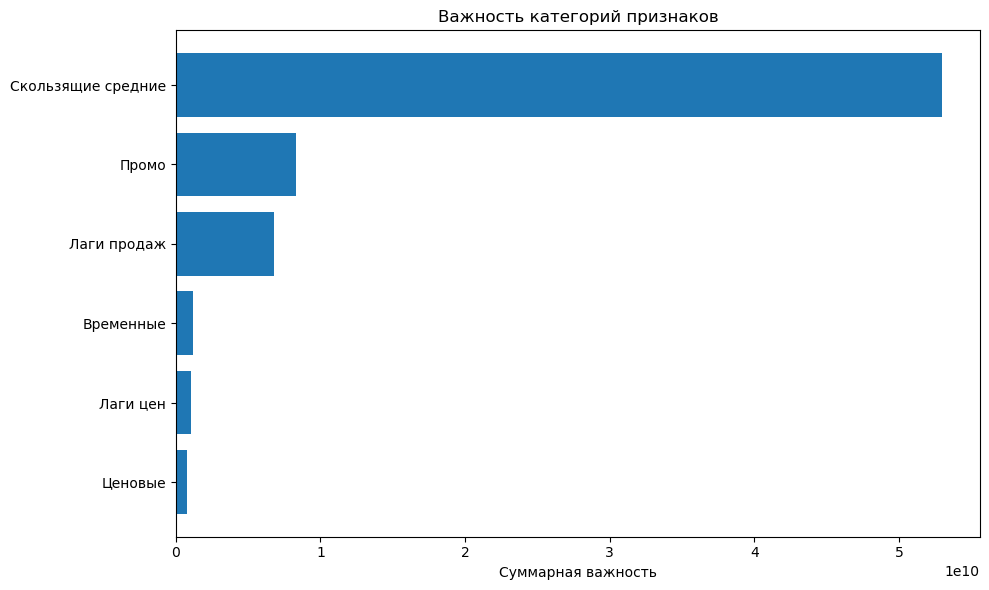

In [51]:
# 1. Важность признаков через feature_importance
importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
})
importance = importance.sort_values('importance', ascending=False)

# Визуализация топ-20 важных признаков
plt.figure(figsize=(12, 8))
sns.barplot(data=importance.head(20), x='importance', y='feature')
plt.title('Топ-20 важных признаков (gain importance)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# 2. Процентная важность признаков
importance['importance_percent'] = importance['importance'] / importance['importance'].sum() * 100
print("\nВажность признаков (в процентах):")
print(importance.head(20).to_string())

# 3. Группировка признаков по категориям
feature_categories = {
    'Временные': ['day_of_week', 'month', 'year', 'is_weekend', 'is_holiday'],
    'Лаги продаж': [col for col in model.feature_name() if 'quantity_lag' in col],
    'Лаги цен': [col for col in model.feature_name() if 'price_lag' in col],
    'Скользящие средние': [col for col in model.feature_name() if 'rolling_mean' in col],
    'Ценовые': ['price', 'price_base', 'normal_price'],
    'Промо': [col for col in model.feature_name() if 'promo' in col or 'discount' in col]
}

category_importance = {}
for category, features in feature_categories.items():
    category_importance[category] = importance[
        importance['feature'].isin(features)
    ]['importance'].sum()

# Визуализация важности категорий признаков
plt.figure(figsize=(10, 6))
category_imp_df = pd.DataFrame({
    'category': category_importance.keys(),
    'importance': category_importance.values()
}).sort_values('importance', ascending=True)

plt.barh(range(len(category_imp_df)), category_imp_df['importance'])
plt.yticks(range(len(category_imp_df)), category_imp_df['category'])
plt.title('Важность категорий признаков')
plt.xlabel('Суммарная важность')
plt.tight_layout()
plt.show()

## Выводы:
Модель в целом улавливает основные тренды продаж. MAE на валидации составляет 3.33 единицы, что говорит о достаточно хорошей точности на уровне отдельных предсказаний.

Модель остановилась на 539 итерации из-за early stopping, что говорит о хорошей сходимости

Важность признаков.Наиболее значимые категории (в порядке убывания):
   - Лаги продаж (особенно lag_7 и lag_14)
   - Скользящие средние (rolling_mean_7 и rolling_mean_14)
   - Ценовые показатели
   - Временные признаки

На графике временного ряда видно, что модель систематически недооценивает пиковые значения продаж. Особенно заметна недооценка в периоды высоких продаж (13, 21 и 25 сентября). Это типичная проблема регрессионных моделей, которые стремятся минимизировать среднюю ошибку.

Scatter plot показывает, что модель имеет тенденцию хорошим предсказаниям в диапазоне 0-1000 единиц. Значительной недооценке при продажах выше 2000 единиц. Б


**Дальнейшие рекомендации и оптимизация:**

Рассмотреть возможность использования отдельных моделей для разных диапазонов продаж. Возможно, стоит применить технику бустинга с разными весами для разных диапазонов значений. Модель может быть полезна для прогнозирования обычных продаж. Нужно с осторожностью использовать прогнозы для периодов пиковых продаж.